# Recursive Feature Elimination(RFE)

##### Recursive Feature Elimination, or RFE for short, is a feature selection algorithm.
##### Feature selection refers to techniques that select a subset of the most relevant features (columns) for a dataset. Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective. Some machine learning algorithms can be misled by irrelevant input features, resulting in worse predictive performance.

* RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

# Importing and Understanding Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
ds = pd.read_csv("Housing.csv")
ds.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


# Data Preparation

In [4]:
#converting columns into numerical value columns

ds["mainroad"] = ds["mainroad"].map({"yes":1,"no":0})
ds["guestroom"] = ds["guestroom"].map({"yes":1,"no":0})
ds["basement"] = ds["basement"].map({"yes":1,"no":0})
ds["hotwaterheating"] = ds["hotwaterheating"].map({"yes":1,"no":0})
ds["airconditioning"] = ds["airconditioning"].map({"yes":1,"no":0})
ds["prefarea"] = ds["prefarea"].map({"yes":1,"no":0})

In [5]:
#creating dummy variable for furnishing column and drop the first one
status = pd.get_dummies(ds["furnishingstatus"],drop_first = True)

In [6]:
#adding the new column in the dataframe
ds = pd.concat([ds,status],axis = 1)

In [8]:
#drop the furnishiung status column from dataframe
ds.drop(["furnishingstatus"],axis = 1,inplace = True)

# Rescaling the data

In [9]:
def norm(x):
    return((x- np.min(x))/(max(x)-min(x)))

#applying noramlization to all columns
ds = ds.apply(norm)

# Spliting the data

In [10]:
X = ds.drop(["price"],axis = 1)
y = ds["price"]

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 22)

In [35]:
#calculating VIF

def vif_cal(input_data,dependent_col):
    vif_df = pd.DataFrame(columns=["Var","Vif"])
    x_vars = input_data.drop([dependent_col],axis = 1)
    xvars_name = x_vars.columns
    
    for i in range(0,xvars_name.shape[0]):
        y = x_vars[xvars_name[i]]
        x = x_vars[xvars_name.drop(xvars_name[i])]
        rsq = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-rsq),2)
        vif_df.loc[i] = [xvars_name[i],vif]
        
    return vif_df.sort_values(by = "Vif",axis = 0,ascending = False,inplace = False)

# RFE

In [24]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [25]:
#Running RFE with the output variable equal to 9
lm = LinearRegression()
rfe = RFE(lm,9)
rfe = rfe.fit(X_train,y_train)

print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False  True False  True  True  True  True False
 False]
[1 1 1 1 2 1 4 1 1 1 1 5 3]


In [26]:
col = X_train.columns[rfe.support_]
col

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'guestroom',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea'],
      dtype='object')

# Building model using Sklearn

In [27]:
#creating train dataframe with the  RFE selected variable
X_train_rfe = X_train[col]

In [29]:
#adding constant 
import statsmodels.api as sm

X_train_rfe = sm.add_constant(X_train_rfe)

In [30]:
lm = sm.OLS(y_train,X_train_rfe).fit()

In [31]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     88.73
Date:                Sat, 10 Apr 2021   Prob (F-statistic):           6.57e-87
Time:                        03:38:21   Log-Likelihood:                 368.03
No. Observations:                 381   AIC:                            -716.1
Df Residuals:                     371   BIC:                            -676.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0440      0.015     

In [36]:
#calculating vif
vif_cal(input_data = ds.drop(["bedrooms"],axis = 1),dependent_col = "price")

,Var,Vif
3,mainroad,5.51
0,area,4.43
2,stories,2.32
10,semi-furnished,2.00
8,parking,1.99
5,basement,1.90
7,airconditioning,1.76
11,unfurnished,1.65
1,bathrooms,1.62
9,prefarea,1.50


In [37]:
# Making Predictions

X_test_rfe = X_test[col]

X_test_rfe = sm.add_constant(X_test_rfe)

y_pred = lm.predict(X_test_rfe)

# Model Evaluation

Text(0, 0.5, 'Housing Price')

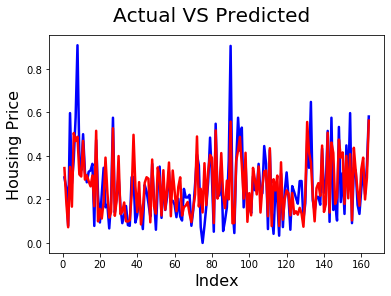

In [40]:
#Actual vs Predicted

c = [i for i in range(1,165,1)]
fig = plt.figure()
plt.plot(c,y_test,color = "blue",linewidth = 2.5,linestyle = "-")
plt.plot(c,y_pred,color = "red",linewidth = 2.5,linestyle = "-")
fig.suptitle("Actual VS Predicted",fontsize = 20)
plt.xlabel("Index",fontsize = 16)
plt.ylabel("Housing Price",fontsize = 16)

Text(0, 0.5, 'Y_pred')

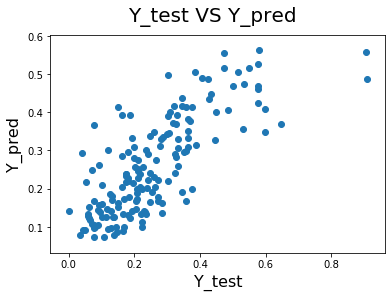

In [41]:
#plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle("Y_test VS Y_pred",fontsize = 20)
plt.xlabel("Y_test",fontsize = 16)
plt.ylabel("Y_pred",fontsize = 16)

Text(0, 0.5, 'y_test-y_pred')

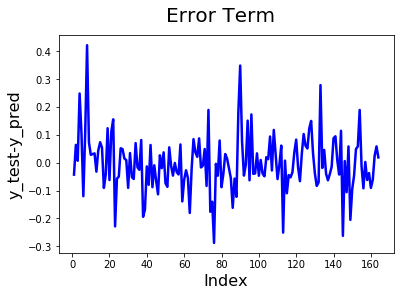

In [42]:
#Error Term
fig = plt.figure()
c = [i for i in range(1,165,1)]
plt.plot(c,y_test-y_pred,color = "blue",linewidth = 2.5,linestyle ="-")
fig.suptitle("Error Term",fontsize = 20)
plt.xlabel("Index",fontsize = 16)
plt.ylabel("y_test-y_pred",fontsize = 16)

Text(0, 0.5, 'Index')

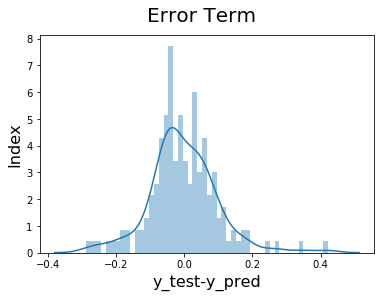

In [43]:
fig = plt.figure()
sns.distplot((y_test-y_pred),bins = 50)
fig.suptitle("Error Term",fontsize = 20)
plt.xlabel("y_test-y_pred",fontsize = 16)
plt.ylabel("Index",fontsize = 16)

In [44]:
from sklearn import metrics
print("RMSE :",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

RMSE : 0.10063536109784997
